In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Preliminary1D import InputGeometry, InputSoluteParameters, InputVariables
from Solver1D import rad_solver_1D
from ParameterSweep1D import ParamSweep1D, ParamSweepPlot1D
from PSOFunctions1D import PSOrad_solver_1D
from PSOFunctions1D import minimiser

# 1D reaction-diffusion case study
## - Utilising 1D solver, parameter sweep, and sensitivity analysis to explore the behaviour of the model.

## - Using parameter optimisation to fit parameter values against data.

#### NB The time taken to run the parameter optimisation and sensitivity analysis sections is non-negigible due to number of model runs required. 

## Part 1 - run parameter sweep 
Code executed here is from 'Manager1D.py' 

In [2]:
# First, preliminary functions setup parameter values, initial conditions, and supporting values
## use help('functionname') for more information on inputs and variable/parameter names

# Model geometry - time and length scales, number of grid points
geom_dict = InputGeometry(L = 1e-3, T = 1e3, nx = 200)

# Model variables - cell and water distribution (fixed), water velocity (non-zero velocity not yet supported)
n, w, uw, parameter_dict = InputVariables(geom_dict, n_option = 'random', nmin = 0.05, nmax = 0.2, m = 0.03)

# Solute initial condition and parameters
c0, param_dict = InputSoluteParameters(parameter_dict, c_int = 0, dt_mult = 100)

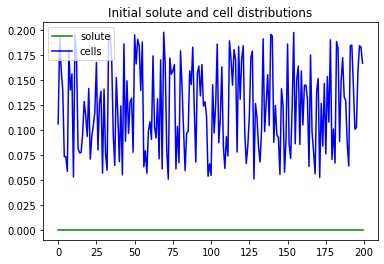

In [3]:
# Plot initial solute and (fixed) cell dsitributions

plt.figure()
plt.plot(c0, 'g')
plt.plot(n, 'b')
plt.legend(('solute', 'cells'))
plt.title('Initial solute and cell distributions')
plt.show()

In [4]:
# Choose parameter to investigate
# e.g alpha - solute production by cells

param_list = [1e-13, 1e-12, 1e-11, 5e-11] #dimensional parameter values for alpha

In [5]:
# Set time to run model (nondimensional)
Tmax = 1
dt = param_dict['dt']
nsteps = int(Tmax / dt)

In [6]:
# Use ParamSweep1D function to run model for each value of alpha, save output as list

clist = ParamSweep1D(c0, n, w, uw, param_list, param_dict, param_name = 'alpha', nsteps = nsteps)

100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


<Figure size 432x288 with 0 Axes>

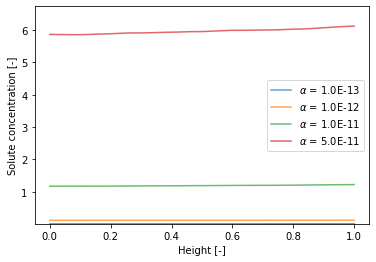

In [7]:
# Use ParamSweepPlot1D function to compare results visually
ParamSweepPlot1D(param_dict, clist, param_list, param_name = 'alpha')

## Part 2 - sensitivity analysis
Now we have manually looked at appropriate parameter ranges using the parameter sweep method, we can use a more formal sensitivity analysis to determine the effect of each parameter on the outcome.

Example output: total solute 

Code executed here is from 'SensitivityAnalysis1D.py'

NB Executing the sensivity analysis takes approx 15 mins on 3 threads with the current settings

In [8]:
from tqdm import tqdm 
import multiprocessing as mp
from multiprocessing import Pool
from SALib.sample import saltelli
from SALib.analyze import sobol
from SensitivityAnalysis1D import multiprocessing_func
import time 

2021-09-24 12:37:00,201 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


number of parameter samples to run = 6144


In [9]:
# Setup sensitivity analysis

# set (dimensional) value bounds for each parameter 
problem = {
    'num_vars': 5,
    'names': ['D', 'alpha', 'kappa', 'K', 'delta'],
    'bounds': [[5e-12, 1e-9],
               [1e-12, 5e-11],
               [1e-15, 1e-12],
               [0.05, 0.2],
               [1e-5, 5e-4]]
}

In [10]:
# use saltelli sampler to generate parameter samples within bounds given 
# number argument in sample should be large as possible (by <1000) for high confidence values 
param_values = saltelli.sample(problem, 256)
nparams = len(param_values)
print(f'Number of parameter samples to run = {nparams}')

Number of parameter samples to run = 3072


In [11]:
# set number of threads to run on
num_cpu = mp.cpu_count() - 1
print(f'Running on {num_cpu} threads')

Running on 3 threads


In [12]:
start_time = time.time()
# run model across num_cpu processes using multiprocessing.Pool module
with Pool(processes = num_cpu) as pool:
    # input function to run, and list of parameter values param_values to run it for
    # returns list of model outputs (ctot) in order of samples passed 
    results = list(tqdm(pool.imap(multiprocessing_func, param_values), total = nparams))
   
# determine time taken
print('time taken', time.time() - start_time)

100%|██████████| 3072/3072 [13:50<00:00,  3.70it/s]


time taken 830.5106980800629


In [13]:
# convert list output to array for analysis by SALib module
results_set = np.array(results)

# use sobol analysis
ST = sobol.analyze(problem, results_set, print_to_console=False)


In [14]:
ST_set = ST['ST'] # sensitivity values
ST_conf = ST['ST_conf'] # confidence values

#print list of parameter names
print(problem['names'])
#print list of sensitivity values (in order as above)
print(ST_set)
#print list of confidence values 
print(ST_conf)


['D', 'alpha', 'kappa', 'K', 'delta']
[1.65389912e-03 9.75896262e-01 2.91831484e-04 2.26899691e-06
 2.70354366e-02]
[1.30171218e-03 1.18268510e-01 5.11518455e-05 7.13350923e-07
 5.14382190e-03]


### Sensitivity analysis results:

List of parameters: 'D', 'alpha', 'kappa', 'K', 'delta'

Sensitivity values: 1.65389912e-03, 9.75896262e-01, 2.91831484e-04, 2.26899691e-06,
 2.70354366e-02
 
Confidence values: 1.30171218e-03, 1.18268510e-01, 5.11518455e-05, 7.13350923e-07,
 5.14382190e-03

 This indicates that alpha, the production rate of the solute by the cells, has the biggest impact on the total solute at this timepoint for this parameter range. However, the confidence value indicates that we need to run more parameter samples to improve the confidence of this value. 
 
 A wider parameter range for kappa (uptake rate of solute) and delta (degradation rate of solute) could also be used as it would be expected these would play a bigger role with larger values. 

## Part 3 - parameter optimisation
Using particle swarm optimisation algorithm (pyswarms) to fit total amount of solute as seen experimentally, with parameter values.

Code executed here is from 'PSO1D.py' file.

NB: running PSO takes approx 20 minutes on 4 threads 

In [15]:
import pyswarms as ps
from PSOFunctions1D import PSOrad_solver_1D
from PSOFunctions1D import minimiser
from Preliminary1D import Nondimensionalise

In [33]:
# Setup model problem as before 

geometry_dict = InputGeometry(L = 1e-3, T = 1e3, nx = 200) 

n, w, uw, parameter_dict = InputVariables(geometry_dict, n_option = "random", nmin = 0.05, nmax = 0.2, m = 0.03)

c0, param_dict = InputSoluteParameters(parameter_dict, c_int = 0, D = 1e-10, dt_mult = 100)


# combine variables and parameters in single dictionary for pyswarms function
maindict = {'n':n, 'w':w, 'uw':uw, 'c0':c0, **param_dict}

In [34]:
#-- set time to run model
Tmax = 0.5
dt = param_dict['dt']
#add number of timesteps as parameter in dictionary 
nsteps = int(Tmax/dt)
maindict['nsteps'] = nsteps
print(nsteps)

40


In [35]:
# Set parameters and bounds to optimise 

parameters = ['alpha', 'kappa']
dim_bounds = [[1e-12, 1e-10], [1e-14, 1e-11]]

min1 = Nondimensionalise(parameter_dict, dimval = dim_bounds[0][0], param_name = parameters[0])
max1 = Nondimensionalise(parameter_dict, dimval = dim_bounds[0][1], param_name = parameters[0])
min2 = Nondimensionalise(parameter_dict, dimval = dim_bounds[1][0], param_name = parameters[1])
max2 = Nondimensionalise(parameter_dict, dimval = dim_bounds[1][1], param_name = parameters[1])

print(min1, max1)
print(min2, max2)

1.0 100.0
0.009999999999999998 10.0


In [37]:
# Configure optimiser

dim = len(parameters)
bounds = ([min1, min2], [max1, max2]) #(dimensionless) bounds from above
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.5} #pyswarms global parameters 

optimizer = ps.single.GlobalBestPSO(n_particles = 20, dimensions = dim, options=options, bounds=bounds)


In [38]:
# Run optimiser and save outputs in txt file

# n_processes is number of threads to run on 
cost, pos = optimizer.optimize(minimiser, iters=100, n_processes = 4, **maindict)

print('cost = ', cost) # difference between optimised and target model output
print('pos = ', pos) # optimum parameter values

with open('pywsarms_output.txt', 'a') as f:
    print(f'alpha, kappa = {pos}', file=f)
    print(f'cost = {cost}', file=f)

2021-09-24 13:46:10,974 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.51e-11
2021-09-24 13:48:13,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.511324895403959e-11, best pos: [16.92148068  5.40079526]


cost =  7.511324895403959e-11
pos =  [16.92148068  5.40079526]


### Parameter optimisation results

Dimensionless value of alpha (production rate): 16.9 (3 s.f.)
Dimensionless value of kappa (uptake rate): 5.40 (3 s.f.)

Cost: 7.51e-11 

We have successfully chosen good bounds for the parameter values, and fit the total amount of solute at Tmax as observed in experiment (set at 7.5 in minimiser function) to our computational model, by finding the values of alpha and kappa that produce this result. 